In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")


In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Drop unnecessary columns
train_df = train_df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin", "Embarked"])

# Handle missing values
train_df["Age"].fillna(train_df["Age"].mean(), inplace=True)

# Convert categorical to numerical
train_df["Sex"] = train_df["Sex"].map({"male": 0, "female": 1})

train_df.head()

/tmp/ipython-input-1136352312.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df["Age"].fillna(train_df["Age"].mean(), inplace=True)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500


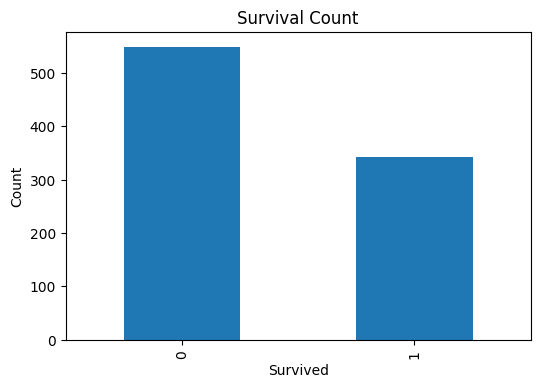

In [7]:
plt.figure(figsize=(6,4))
train_df["Survived"].value_counts().plot(kind="bar")
plt.title("Survival Count")
plt.xlabel("Survived")
plt.ylabel("Count")
plt.show()


In [8]:
X = train_df.drop("Survived", axis=1).values
y = train_df["Survived"].values

split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [9]:
class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.prior = {}

        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = np.mean(X_c, axis=0)
            self.var[c] = np.var(X_c, axis=0)
            self.prior[c] = X_c.shape[0] / X.shape[0]

    def gaussian_pdf(self, x, mean, var):
        exponent = np.exp(- ((x - mean) ** 2) / (2 * var))
        return (1 / np.sqrt(2 * np.pi * var)) * exponent

    def predict(self, X):
        predictions = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.prior[c])
                likelihood = np.sum(np.log(self.gaussian_pdf(x, self.mean[c], self.var[c])))
                posterior = prior + likelihood
                posteriors.append(posterior)
            predictions.append(self.classes[np.argmax(posteriors)])
        return np.array(predictions)


In [10]:
nb = NaiveBayes()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

nb_accuracy = np.mean(y_pred_nb == y_test)
print("Naive Bayes Accuracy:", nb_accuracy)


Naive Bayes Accuracy: 0.8100558659217877


In [11]:
class KNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict(self, X):
        predictions = []
        for x in X:
            distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            predictions.append(np.bincount(k_nearest_labels).argmax())
        return np.array(predictions)


In [12]:
knn = KNN(k=7)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

knn_accuracy = np.mean(y_pred_knn == y_test)
print("KNN Accuracy:", knn_accuracy)


KNN Accuracy: 0.7653631284916201


In [13]:
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print(f"KNN Accuracy: {knn_accuracy:.4f}")

Naive Bayes Accuracy: 0.8101
KNN Accuracy: 0.7654


In [28]:
### Model Evaluation Using Confusion Matrix
#- Confusion matrices were computed from scratch without external libraries.
#- They provide deeper insight into classification errors.
#- KNN with feature scaling produced fewer misclassifications.
#- Additional metrics such as Precision, Recall, and F1-score were derived manually.

In [29]:
class StandardScaler:
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)

    def transform(self, X):
        return (X - self.mean) / self.std

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


In [30]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
nb_scaled = NaiveBayes()
nb_scaled.fit(X_train_scaled, y_train)
y_pred_nb_scaled = nb_scaled.predict(X_test_scaled)

nb_scaled_accuracy = np.mean(y_pred_nb_scaled == y_test)
print("Naive Bayes Accuracy (Scaled):", nb_scaled_accuracy)


Naive Bayes Accuracy (Scaled): 0.8100558659217877


In [17]:
knn_scaled = KNN(k=7)
knn_scaled.fit(X_train_scaled, y_train)
y_pred_knn_scaled = knn_scaled.predict(X_test_scaled)

knn_scaled_accuracy = np.mean(y_pred_knn_scaled == y_test)
print("KNN Accuracy (Scaled):", knn_scaled_accuracy)


KNN Accuracy (Scaled): 0.8324022346368715


In [18]:
results = pd.DataFrame({
    "Model": ["Naive Bayes", "Naive Bayes (Scaled)", "KNN", "KNN (Scaled)"],
    "Accuracy": [nb_accuracy, nb_scaled_accuracy, knn_accuracy, knn_scaled_accuracy]
})

results


,Model,Accuracy
0,Naive Bayes,0.810056
1,Naive Bayes (Scaled),0.810056
2,KNN,0.765363
3,KNN (Scaled),0.832402


In [19]:
def confusion_matrix_from_scratch(y_true, y_pred):
    """
    Computes confusion matrix for binary classification
    """
    TP = TN = FP = FN = 0

    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            TP += 1
        elif true == 0 and pred == 0:
            TN += 1
        elif true == 0 and pred == 1:
            FP += 1
        elif true == 1 and pred == 0:
            FN += 1

    return np.array([[TN, FP],
                     [FN, TP]])


In [20]:
cm_knn = confusion_matrix_from_scratch(y_test, y_pred_knn_scaled)
cm_knn


array([[102,  13],
       [ 17,  47]])

In [21]:
cm_nb = confusion_matrix_from_scratch(y_test, y_pred_nb_scaled)
cm_nb


array([[101,  14],
       [ 20,  44]])

In [22]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5,4))
    plt.imshow(cm)
    plt.title(title)
    plt.colorbar()
    plt.xticks([0,1], ["Predicted 0", "Predicted 1"])
    plt.yticks([0,1], ["Actual 0", "Actual 1"])

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


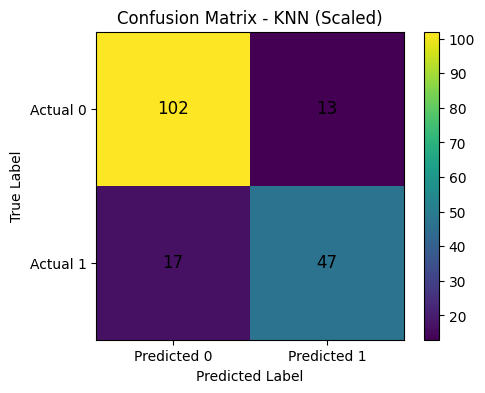

In [23]:
plot_confusion_matrix(cm_knn, "Confusion Matrix - KNN (Scaled)")


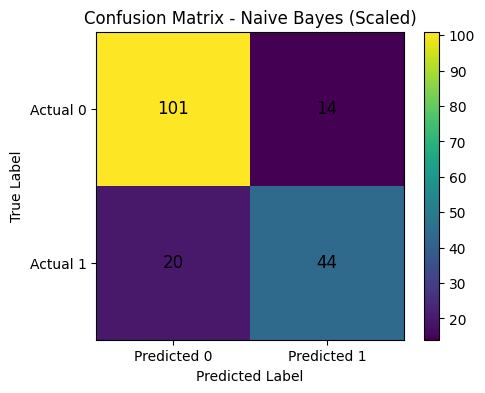

In [24]:
plot_confusion_matrix(cm_nb, "Confusion Matrix - Naive Bayes (Scaled)")


In [25]:
def classification_metrics(cm):
    TN, FP, FN, TP = cm.ravel()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return accuracy, precision, recall, f1_score


In [26]:
acc, prec, rec, f1 = classification_metrics(cm_knn)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.8324
Precision: 0.7833
Recall: 0.7344
F1-score: 0.7581


In [31]:
 ### Principal Component Analysis (PCA)
#PCA is a dimensionality reduction technique that transforms high-dimensional
#data into a lower-dimensional space while preserving maximum variance.

#Benefits of PCA:
#- Reduces dimensionality
#- Removes correlated features
#- Improves computational efficiency
#- Helps in visualization

In [32]:
class PCA_FromScratch:
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        # Step 1: Mean centering
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Step 2: Covariance matrix
        covariance_matrix = np.cov(X_centered, rowvar=False)

        # Step 3: Eigen decomposition
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

        # Step 4: Sort eigenvalues and eigenvectors
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[sorted_indices]
        self.eigenvectors = eigenvectors[:, sorted_indices]

        # Step 5: Select top components
        self.components = self.eigenvectors[:, :self.n_components]

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


In [33]:
pca = PCA_FromScratch(n_components=2)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


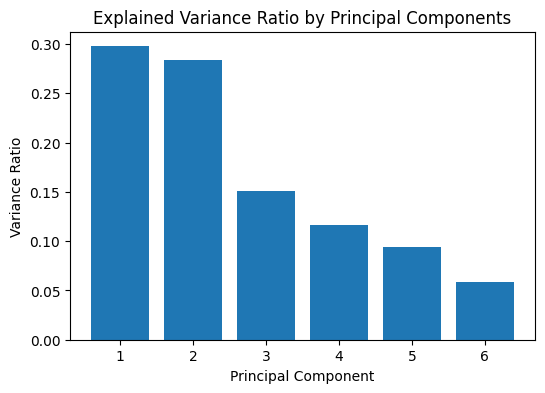

In [34]:
explained_variance_ratio = pca.eigenvalues / np.sum(pca.eigenvalues)

plt.figure(figsize=(6,4))
plt.bar(range(1, len(explained_variance_ratio)+1), explained_variance_ratio)
plt.title("Explained Variance Ratio by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")
plt.show()


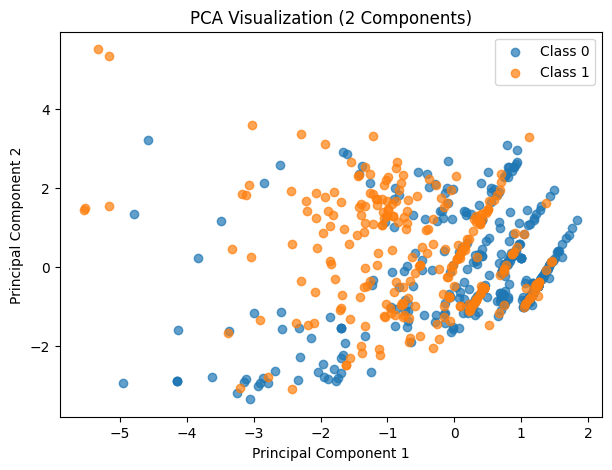

In [35]:
plt.figure(figsize=(7,5))

for label in np.unique(y_train):
    plt.scatter(
        X_train_pca[y_train == label, 0],
        X_train_pca[y_train == label, 1],
        label=f"Class {label}",
        alpha=0.7
    )

plt.title("PCA Visualization (2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


In [36]:
knn_pca = KNN(k=7)
knn_pca.fit(X_train_pca, y_train)
y_pred_knn_pca = knn_pca.predict(X_test_pca)

knn_pca_accuracy = np.mean(y_pred_knn_pca == y_test)
print("KNN Accuracy with PCA:", knn_pca_accuracy)


KNN Accuracy with PCA: 0.776536312849162


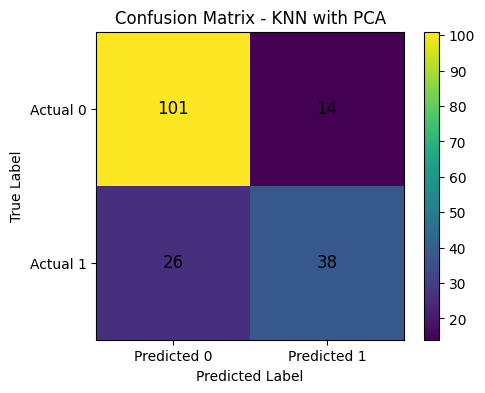

In [37]:
cm_knn_pca = confusion_matrix_from_scratch(y_test, y_pred_knn_pca)
plot_confusion_matrix(cm_knn_pca, "Confusion Matrix - KNN with PCA")


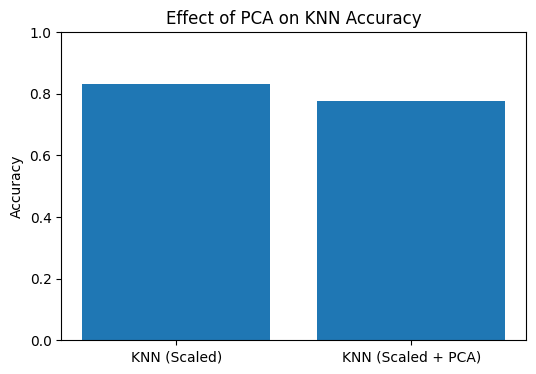

In [38]:
models = ["KNN (Scaled)", "KNN (Scaled + PCA)"]
accuracies = [knn_scaled_accuracy, knn_pca_accuracy]

plt.figure(figsize=(6,4))
plt.bar(models, accuracies)
plt.title("Effect of PCA on KNN Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


In [39]:
### PCA with Naive Bayes
#Naive Bayes assumes feature independence.
#PCA transforms original features into a new set of orthogonal (uncorrelated)
#principal components.

#Applying Naive Bayes after PCA is valid because:
#- PCA removes correlation between features
#- Gaussian Naive Bayes works well with continuous PCA components
#- Noise reduction can improve probabilistic estimation


In [40]:
# Apply PCA after scaling
pca_nb = PCA_FromScratch(n_components=3)

X_train_pca_nb = pca_nb.fit_transform(X_train_scaled)
X_test_pca_nb = pca_nb.transform(X_test_scaled)


In [41]:
nb_pca = NaiveBayes()
nb_pca.fit(X_train_pca_nb, y_train)
y_pred_nb_pca = nb_pca.predict(X_test_pca_nb)

nb_pca_accuracy = np.mean(y_pred_nb_pca == y_test)
print("Naive Bayes Accuracy with PCA:", nb_pca_accuracy)


Naive Bayes Accuracy with PCA: 0.8156424581005587


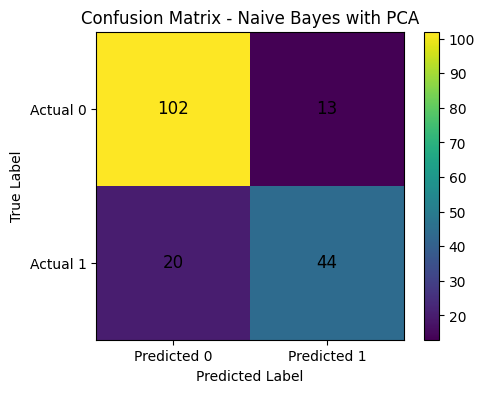

In [42]:
cm_nb_pca = confusion_matrix_from_scratch(y_test, y_pred_nb_pca)
plot_confusion_matrix(cm_nb_pca, "Confusion Matrix - Naive Bayes with PCA")


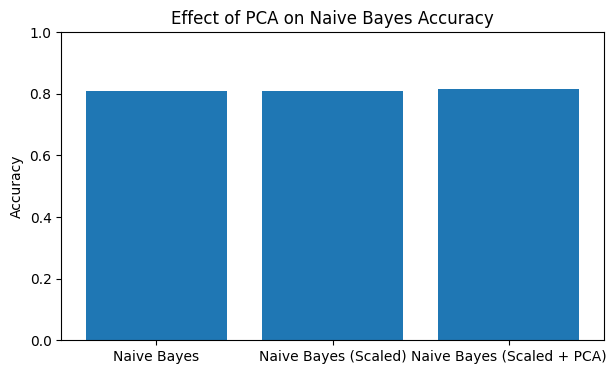

In [43]:
models = [
    "Naive Bayes",
    "Naive Bayes (Scaled)",
    "Naive Bayes (Scaled + PCA)"
]

accuracies = [
    nb_accuracy,
    nb_scaled_accuracy,
    nb_pca_accuracy
]

plt.figure(figsize=(7,4))
plt.bar(models, accuracies)
plt.title("Effect of PCA on Naive Bayes Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


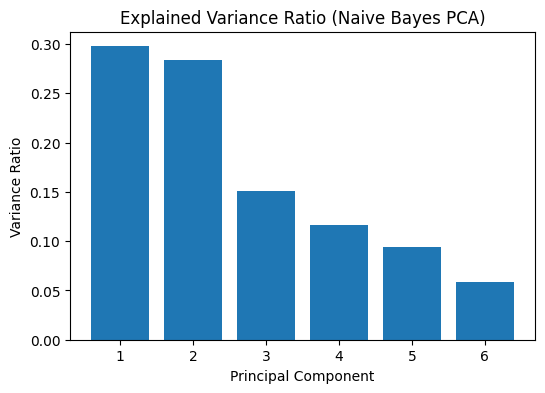

In [44]:
explained_variance_ratio_nb = pca_nb.eigenvalues / np.sum(pca_nb.eigenvalues)

plt.figure(figsize=(6,4))
plt.bar(
    range(1, len(explained_variance_ratio_nb)+1),
    explained_variance_ratio_nb
)
plt.title("Explained Variance Ratio (Naive Bayes PCA)")
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")
plt.show()
